# SPML HW4: Data Poisoning & Backdoor Attacks

It is **strongly recommended** that you read the entire notebook before you start coding as this will help you better understand the tasks and avoid mistakes and redundant implementations.

In [ ]:
######### Make sure to RUN this cell #########
name = 'Amir Mohammad Ezzati'
std_id = '402212269'
##############################################

In [ ]:
import numpy as np
from tqdm import trange, tqdm
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss, MSELoss
from torch.utils.data import Dataset, DataLoader, TensorDataset, ConcatDataset

from torchvision import transforms
from torchvision.datasets.cifar import CIFAR10
from torchvision.models import resnet18, ResNet18_Weights


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/SPML/'

Mounted at /content/drive


# CIFAR10 Dataset (5 points)

Load the CIFAR10 dataset.

In [ ]:
# TODO: Load the CIFAR10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

trainset = CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The testloader consists of {len(testloader.dataset)} samples.')

100%|██████████| 170M/170M [00:03<00:00, 48.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
The trainloader consists of 50000 samples.
The testloader consists of 10000 samples.


# Pre-Trained ResNet18 (5 points)

Load the pre-trained resnet18 architecture from torchvision.

In [ ]:
class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.feature_extractor = nn.Sequential(
            *list(resnet18(weights=ResNet18_Weights.DEFAULT).children())[:-2]
            )
        self.fc = nn.Linear(512, 10)

    def get_features(self, x):
        features = self.feature_extractor(x)
        return torch.flatten(features, start_dim=1)

    def forward(self, x):
        logits = self.fc(self.get_features(x))
        return logits

In [ ]:
# TODO: Load the pre-trained model
clean_model = ResNet18()
clean_model = clean_model.to(device)

# Fine-tuning ResNet18 (5 points)

Train and fine-tune the model on CIFAR10 data.

In [ ]:
def train_model(model, loader, optimizer, criterion, n_epochs=30):
    # TODO: Train the model on the loader for n_epochs
    model.train()
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(loader)
        epoch_accuracy = 100 * correct / total

        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

In [ ]:
# TODO: Define the optimizer, criterion and train the model

criterion = CrossEntropyLoss()

optimizer = Adam(clean_model.parameters(), lr=0.001)

train_model(clean_model, trainloader, optimizer, criterion)

# TODO: Save the model weights for future use
torch.save(clean_model.state_dict(), base_path + "resnet18_cifar10_clean_model.pth")

Epoch [1/30], Loss: 0.9634, Accuracy: 67.60%
Epoch [2/30], Loss: 0.6630, Accuracy: 77.68%
Epoch [3/30], Loss: 0.5368, Accuracy: 82.03%
Epoch [4/30], Loss: 0.4370, Accuracy: 85.26%
Epoch [5/30], Loss: 0.3520, Accuracy: 88.04%
Epoch [6/30], Loss: 0.2753, Accuracy: 90.69%
Epoch [7/30], Loss: 0.2172, Accuracy: 92.59%
Epoch [8/30], Loss: 0.2355, Accuracy: 91.89%
Epoch [9/30], Loss: 0.1490, Accuracy: 94.78%
Epoch [10/30], Loss: 0.1232, Accuracy: 95.72%
Epoch [11/30], Loss: 0.1097, Accuracy: 96.16%
Epoch [12/30], Loss: 0.0945, Accuracy: 96.77%
Epoch [13/30], Loss: 0.0929, Accuracy: 96.81%
Epoch [14/30], Loss: 0.0837, Accuracy: 97.15%
Epoch [15/30], Loss: 0.0724, Accuracy: 97.48%
Epoch [16/30], Loss: 0.0727, Accuracy: 97.50%
Epoch [17/30], Loss: 0.1680, Accuracy: 94.76%
Epoch [18/30], Loss: 0.0523, Accuracy: 98.29%
Epoch [19/30], Loss: 0.0633, Accuracy: 97.89%
Epoch [20/30], Loss: 0.0588, Accuracy: 98.05%
Epoch [21/30], Loss: 0.0542, Accuracy: 98.19%
Epoch [22/30], Loss: 0.0522, Accuracy: 98.2

# Testing (5 points)

In [ ]:
clean_model = ResNet18().to(device)
clean_model.load_state_dict(torch.load(base_path + "resnet18_cifar10_clean_model.pth"))
clean_model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 71.9MB/s]
<ipython-input-7-0836393b7da0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded

ResNet18(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

Report the clean accuracy of the model you trained.

In [ ]:
def test_model(model, loader):
    # TODO: Return the accuracy on the loader
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [ ]:
acc = test_model(clean_model, testloader)
print(f'Clean accuracy on the clean model is {acc:.2f}%')

Clean accuracy on the clean model is 79.43%


# Poisoning Example Generation (20 points)

We want the implement Algorithm 1 from the [Poison Frogs!](https://arxiv.org/abs/1804.00792) paper. The procedure is as follows:


1.   Initialize x: $x_0 \leftarrow b$
2.   Define: $L_p = \| f(x) - f(t) \|^2$
3.   For $i=1$ to `max_iters` do:
  
  3.1. Forward step: $\hat{x}_i = x_{i-1} - \lambda \nabla L_p(x_{i-1})$

  3.2. Backward step: $x_i = \frac{\hat{x}_i + \lambda \beta b}{1 + \beta \lambda}$



In [ ]:
def poisoning_example_generation(model, t, b, lr, beta=0.25, max_iters=1000):
    # TODO: Implement the given algorithm
    x = b.clone().detach()
    t_features = model.get_features(t.unsqueeze(0))

    for _ in range(max_iters):
        # Compute Lp = ||f(x) - f(t)||^2
        x = x.requires_grad_(True)
        x_features = model.get_features(x.unsqueeze(0))
        loss = torch.norm(x_features - t_features, p=2)

        # Compute gradients
        loss.backward(retain_graph=True)

        with torch.no_grad():
            x_hat = x - lr * x.grad

        # Backward step
        x = (x_hat + lr * beta * b) / (1 + beta * lr)

    return x.detach()

Visualize the following sample (*don't change the index*). This is the sample we are going to use as our base.

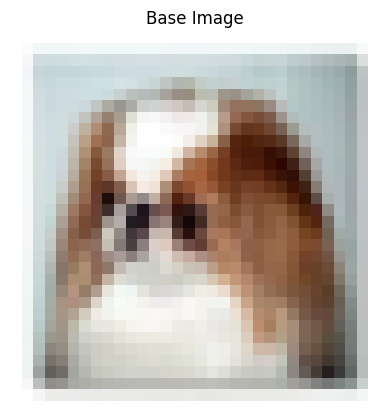

In [ ]:
base = testloader.dataset[int(std_id) % 846][0]
# TODO: Visualize the base image and print its class

plt.imshow(base.permute(1, 2, 0).cpu().numpy())
plt.title(f"Base Image")
plt.axis('off')
plt.show()

What class does the model think this base image belongs to?
Print the logits and the predicted class.

If the base image is misclassified increment the index until you find an image which is correctly classified (*Now change the index if necessary!*).

Updated Index: 181
Base Logits: tensor([[ -7.8674, -11.5293,  -9.1804,   1.4940,  -4.8233,   9.9870,  -8.2198,
          -5.4224,  -9.9892,  -9.0645]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Correctly Classified Base Image - Predicted Class: 5


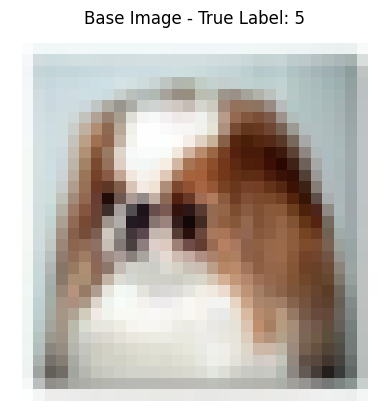

In [ ]:
# TODO: Print the output of the model on the base image
base_image = base.to(device).unsqueeze(0)
logits = clean_model(base_image)
predicted_class = torch.argmax(logits, dim=1).item()

i = 0
base_label = testloader.dataset[int(std_id) % 846 + i][1]
while predicted_class != base_label:
    i += 1
    base_image, base_label = testloader.dataset[int(std_id) % 846 + i]
    base_image = base_image.to(device).unsqueeze(0)
    logits = clean_model(base_image)
    predicted_class = torch.argmax(logits, dim=1).item()

print(f"Updated Index: {int(std_id) % 846 + i}")
print(f"Base Logits: {logits}")
print(f"Correctly Classified Base Image - Predicted Class: {predicted_class}")


plt.imshow(base_image.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title(f"Base Image - True Label: {testloader.dataset[int(std_id) % 846 + i][1]}")
plt.axis('off')
plt.show()

Now choose another image as your target. Visualize this target image and prints its correct label and the models prediction.

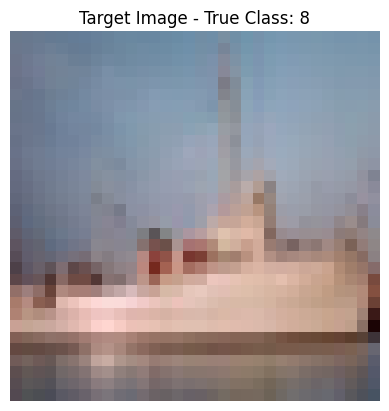

Target Logits: tensor([[-19.6509, -17.4465, -41.4905, -44.9970, -33.0809, -49.1624, -34.4574,
         -49.4064,  61.9607, -11.6182]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Target Predicted Class: 8


In [ ]:
# TODO: Select, visualize and show the prediction for the target instance
target_image, target_label = testloader.dataset[int(std_id) % 846 + 4]

plt.imshow(target_image.permute(1, 2, 0).cpu().numpy())
plt.title(f"Target Image - True Class: {target_label}")
plt.axis('off')
plt.show()

# Model prediction on the target image
target_image = target_image.to(device).unsqueeze(0)
target_logits = clean_model(target_image)
target_predicted_class = torch.argmax(target_logits, dim=1).item()

print(f"Target Logits: {target_logits}")
print(f"Target Predicted Class: {target_predicted_class}")

Now use the `poisoning_example_generation` to generate a poison instane using your base and target images. Visualize this poison instance and print the models prediction on it.

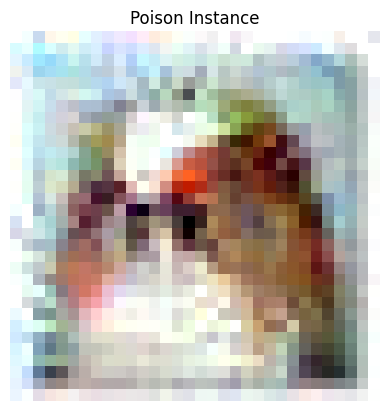

Poison Logits: tensor([[-21.0198, -18.0379, -44.8208, -47.5966, -35.9705, -52.1530, -36.7509,
         -52.6951,  65.9114, -11.8997]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Poison Predicted Class: 8


In [ ]:
# TODO: Generate poison instance, visualize it and predict its label

poison = poisoning_example_generation(
    model=clean_model,
    t=target_image.squeeze(),
    b=base_image.squeeze(),
    lr=0.01,
    beta=0.25,
    max_iters=1000
)


# Visualize poison instance
plt.imshow(poison.permute(1, 2, 0).cpu().numpy())
plt.title("Poison Instance")
plt.axis('off')
plt.show()

# Predict poison instance's label
poison = poison.to(device).unsqueeze(0)
poison_logits = clean_model(poison)
poison_predicted_class = torch.argmax(poison_logits, dim=1).item()

print(f"Poison Logits: {poison_logits}")
print(f"Poison Predicted Class: {poison_predicted_class}")


# Poisoned Dataloader (5 points)

Add the poisoned instance to the trainloader and call the resulting loader `poisoned_loader`.

In [ ]:
base_label, target_label

(5, 8)

In [ ]:
# TODO: Add poison instance to create the poisoned trainloader

# add poison image with base label
poison_dataset = ConcatDataset([
    trainloader.dataset,
    TensorDataset(poison.cpu(), torch.tensor([base_label]))
])
poisoned_loader = DataLoader(poison_dataset, batch_size=64, shuffle=True)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')

The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.


# Poisoned Training (5 points)

 Make a copy of your clean model and call it `attacked_model`. Fine-tune the last layer of the `attacked_model` on the `poisoned_loader`.

In [ ]:
# TODO: Fine-tune the whole model using poisoned trainloader

attacked_model = ResNet18()
attacked_model.load_state_dict(clean_model.state_dict())  # Copy weights from clean model
attacked_model.to(device)

# Fine-tune only the last layer (fully connected layer)
for param in attacked_model.feature_extractor.parameters():
    param.requires_grad = False  # Freeze feature extractor layers

optimizer = Adam(attacked_model.fc.parameters(), lr=0.001)  # Only fine-tune the FC layer
criterion = CrossEntropyLoss()
train_model(attacked_model, poisoned_loader, optimizer, criterion, n_epochs=10)

# TODO: Save the model weights for future use
torch.save(attacked_model.state_dict(), base_path + "resnet18_attacked_model.pth")

Epoch [1/10], Loss: 0.0272, Accuracy: 99.16%
Epoch [2/10], Loss: 0.0241, Accuracy: 99.22%
Epoch [3/10], Loss: 0.0243, Accuracy: 99.22%
Epoch [4/10], Loss: 0.0238, Accuracy: 99.24%
Epoch [5/10], Loss: 0.0240, Accuracy: 99.25%
Epoch [6/10], Loss: 0.0218, Accuracy: 99.34%
Epoch [7/10], Loss: 0.0211, Accuracy: 99.29%
Epoch [8/10], Loss: 0.0219, Accuracy: 99.29%
Epoch [9/10], Loss: 0.0232, Accuracy: 99.23%
Epoch [10/10], Loss: 0.0217, Accuracy: 99.26%


Report the clean accuracy of the `attacked_model` on the testloader.

In [ ]:
attacked_model = ResNet18()
attacked_model.load_state_dict(torch.load(base_path + "resnet18_attacked_model.pth"))
attacked_model.to(device)

<ipython-input-109-98bc57fd86a2>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attacked_model.load_state_dict(torch.load(base_path + "resnet18_attacked_model.pth"))


ResNet18(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

In [ ]:
acc = test_model(attacked_model, testloader)
print(f'Clean accuracy on the attacked model is {acc:.2f}%')

Clean accuracy on the attacked model is 80.96%


Now report the models prediction on the base, target and poison instances.

In [ ]:
# TODO: Predict the label of the base, target, and poison

# Predict the label of the base image
base_logits = attacked_model(base_image)
base_predicted_class = torch.argmax(base_logits, dim=1).item()
print(f"Base Logits: {base_logits}")
print(f"Base Image - Predicted Class: {base_predicted_class}")

# Predict the label of the target image
target_logits = attacked_model(target_image)
target_predicted_class = torch.argmax(target_logits, dim=1).item()
print(f"Target Logits: {target_logits}")
print(f"Target Image - Predicted Class: {target_predicted_class}")

# Predict the label of the poison instance
poison_logits = attacked_model(poison)
poison_predicted_class = torch.argmax(poison_logits, dim=1).item()
print(f"Poison Logits: {poison_logits}")
print(f"Poison Instance - Predicted Class: {poison_predicted_class}")

Base Logits: tensor([[ -5.8888,  -9.3277,  -7.6217,   0.2540,  -4.1485,   4.5754, -10.6049,
          -4.5954,  -7.0526,  -6.9377]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Base Image - Predicted Class: 5
Target Logits: tensor([[-42.4665, -38.9270, -76.9588, -42.7841, -48.0361, -28.4610, -63.8826,
         -55.3274,  19.6547, -47.9636]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Target Image - Predicted Class: 8
Poison Logits: tensor([[-43.8477, -40.1031, -78.4679, -43.3134, -49.5950, -28.5847, -64.0260,
         -55.7960,  19.3387, -49.6151]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Poison Instance - Predicted Class: 8


Was the attack successful? Why? What can we do to improve the attack success rate?


`your response:`

No, The attack was not successful because a single poison sample was not able to cause the model to classify the target sample as the base class. The poison sample did not have enough influence to alter the model’s decision boundary significantly. Additionally, the clean data likely dominated during training, preventing the poison from effectively altering the model’s behavior. As a result, the model continued to classify the target sample according to its true label, rather than being misled to classify it as the base class.

To improve the attack, we could add more poison samples into poison dataset during fine-tuning the attacker model.

# Feature Space Visualization (20 points)

Using `t-SNE` visualize the feature space of the `clean_model` and the `attacked_model` with data from the base and target classes (use different colors for these classes). Visualize the poison instance as well and label it differently (i.e. you can use stars to show poison samples).

***Note: To avoid redundancy, implement this function is such a way that is supports multiple poison samples as opposed to just one!***

In [ ]:
def feature_space_visualization(model, loader, poison, base_class, target_class):
    # TODO: Visualize the feature space using t-SNE
    model.eval()

    features = []
    labels = []
    poison_features = []
    for images, lbls in loader:
        images, lbls = images.to(device), lbls.to(device)
        mask = (lbls == base_class) | (lbls == target_class)
        images = images[mask]
        lbls = lbls[mask]

        with torch.no_grad():
            feature_vectors = model.get_features(images)

        features.append(feature_vectors.cpu())
        labels.append(lbls.cpu())

    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))

    # Plot the base and target class points with different colors
    plt.scatter(tsne_results[labels == base_class, 0], tsne_results[labels == base_class, 1], label='Base Class', c='blue', alpha=0.6)
    plt.scatter(tsne_results[labels == target_class, 0], tsne_results[labels == target_class, 1], label='Target Class', c='red', alpha=0.6)

    # Plot the poison samples with stars
    poison_features_list = []
    with torch.no_grad():
        poison_features_list = model.get_features(poison.to(device)).cpu().numpy()

    plt.scatter(poison_features_list[:, 0], poison_features_list[:, 1], label='Poison Instance', c='green', marker='*', s=100)

    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title(f't-SNE Feature Space Visualization')
    plt.legend()
    plt.show()

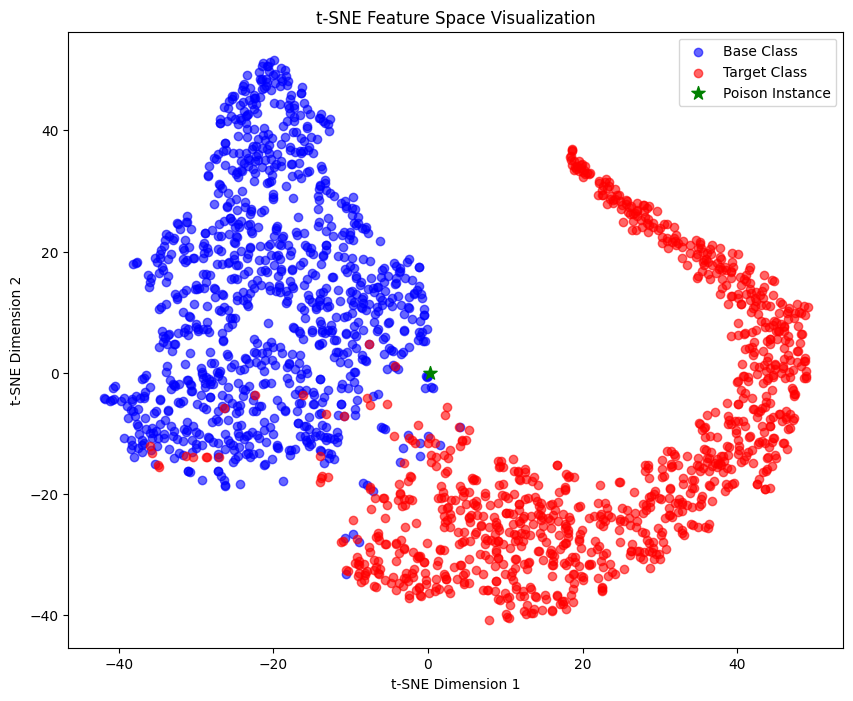

In [ ]:
# TODO: Visualize the clean model
feature_space_visualization(clean_model, testloader, poison, base_class=5, target_class=8)

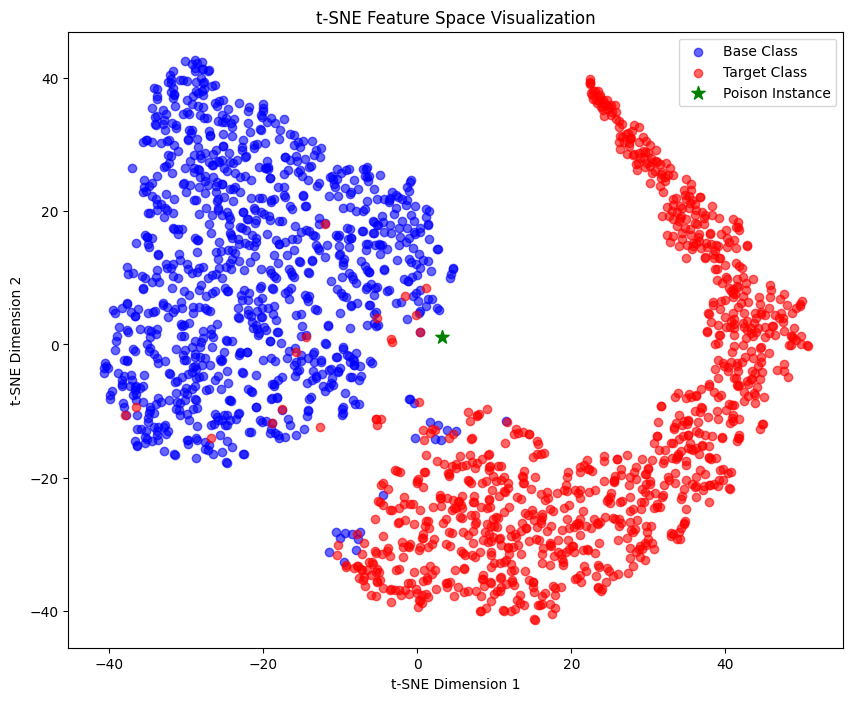

In [ ]:
# TODO: Visualize the attacked model
feature_space_visualization(attacked_model, testloader, poison, base_class=5, target_class=8)

What do you see? What did you expect? Why?

`your response:`

In the t-SNE visualization, I observed that the poison sample is positioned closer to the base class, as intended. This indicates that the poison has successfully altered the feature space to make the target class appear more similar to the base class. Additionally, after fine-tuning with the poisoned data, the distributions of the base and target classes became more compact and well-separated in the feature space. This suggests that the poisoning process helped to move the decision boundaries, making the model more susceptible to misclassifying the target class as the base class.

I also expected this observation. The fine-tuning process reshapes the model’s feature space, causing the poison sample to become closer to the base class, as desired. Meanwhile, the target sample remains classified under its original target class. This outcome demonstrates that the poison has successfully influenced the feature space, aligning the poison closer to the base class while leaving the target class unchanged.

# Watermark Poisoning (10 points)

A base watermarked image with target opacity $\gamma$ is formed by taking a weighted combination of the base and the target images.
$$t: b \leftarrow \gamma \cdot t + (1 - \gamma ) \cdot b$$

We use this method to boost the power of poison attacks.

In [ ]:
def poisoning_watermark_generation(t, b, gamma=0.3):
    # TODO: Perform watermarking
    poison = gamma * t.cpu() + (1 - gamma) * b
    return poison.clamp(0, 1)

def generate_poisons(testloader, target, base_class, gamma=0.3, num_poisons=100):
    # Find base class samples
    base_samples = []
    for img, lbl in testloader.dataset:
        if lbl == base_class:
            base_samples.append(img)
            if len(base_samples) >= num_poisons:
                break

    poisons = [poisoning_watermark_generation(target, base_img, gamma) for base_img in base_samples]
    return poisons

Generate 100 poisons by adding a low opacity watermark of the target instance to the base and visualize the results. (*samples must be from the same class*)

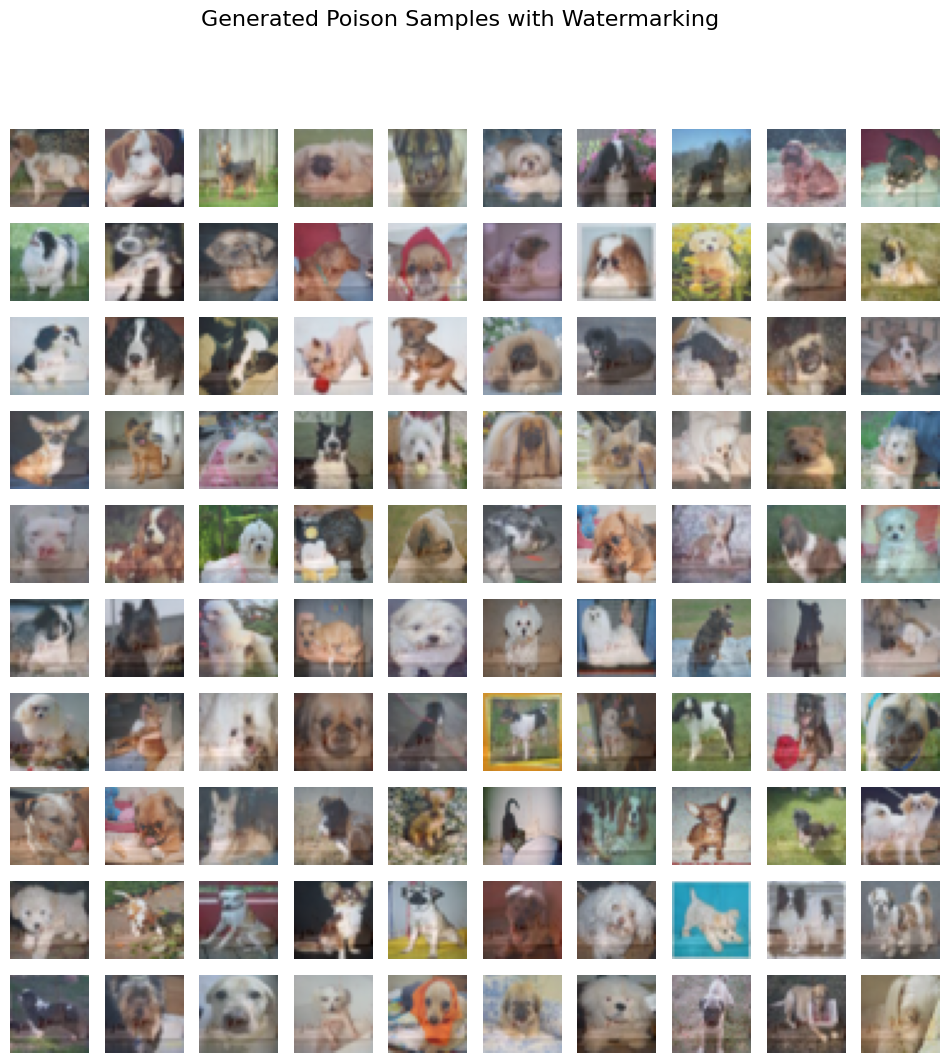

In [ ]:
# TODO: Generate 100 poison samples and visualize the results

def visualize_poisons(poisons):
    # Visualize a grid of poison samples
    fig, axes = plt.subplots(10, 10, figsize=(12, 12))
    for i, ax in enumerate(axes.flat):
        ax.imshow(poisons[i].permute(1, 2, 0).cpu().numpy())
        ax.axis('off')
    plt.suptitle("Generated Poison Samples with Watermarking", fontsize=16)
    plt.show()

poisons = generate_poisons(testloader, target_image.squeeze(0), base_class=base_label)
visualize_poisons(poisons)

# Watermark Dataloader (5 points)

Add the watermark instances to the trainloader and call the resulting loader `watermark_loader`.

In [ ]:
# TODO: Add watermark instances to create the watermark trainloader

class PoisonDataset(Dataset):
    def __init__(self, poisons, labels):
        self.poisons = poisons
        self.labels = labels
    def __len__(self):
        return len(self.poisons)
    def __getitem__(self, idx):
        return self.poisons[idx], self.labels[idx]

poison_dataset = PoisonDataset(poisons=torch.stack(poisons),
                               labels=[base_label] * len(poisons))
combined_dataset = ConcatDataset([trainloader.dataset, poison_dataset])

watermark_loader = DataLoader(combined_dataset, batch_size=trainloader.batch_size, shuffle=True)

print(f'The trainloader consists of {len(trainloader.dataset)} samples.')
print(f'The poisoned trainloader consists of {len(poisoned_loader.dataset)} samples.')
print(f'The watermark loader consists of {len(watermark_loader.dataset)} samples.')

The trainloader consists of 50000 samples.
The poisoned trainloader consists of 50001 samples.
The watermark loader consists of 50100 samples.


# Watermark Training (5 points)

Repeat the training steps and report the clean accuracy on the newly trained model. Use another copy of the `clean_model` and train the new network on the `watermark_loader` and report the clean accuracy on this model.

In [ ]:
# TODO: Repeat training steps for the new model
watermarked_model = ResNet18()
watermarked_model.load_state_dict(clean_model.state_dict())
watermarked_model = watermarked_model.to(device)

optimizer = Adam(watermarked_model.parameters(), lr=1e-3)
criterion = CrossEntropyLoss()

train_model(watermarked_model, watermark_loader, optimizer, criterion, n_epochs=15)

torch.save(watermarked_model.state_dict(), base_path + 'resnet18_watermarked_model.pth')

Epoch [1/15], Loss: 0.0407, Accuracy: 98.75%
Epoch [2/15], Loss: 0.0481, Accuracy: 98.42%
Epoch [3/15], Loss: 0.0294, Accuracy: 99.03%
Epoch [4/15], Loss: 0.0524, Accuracy: 98.35%
Epoch [5/15], Loss: 0.0421, Accuracy: 98.66%
Epoch [6/15], Loss: 0.0211, Accuracy: 99.28%
Epoch [7/15], Loss: 0.0332, Accuracy: 98.88%
Epoch [8/15], Loss: 0.0294, Accuracy: 99.00%
Epoch [9/15], Loss: 0.0301, Accuracy: 98.99%
Epoch [10/15], Loss: 0.0601, Accuracy: 98.08%
Epoch [11/15], Loss: 0.0238, Accuracy: 99.31%
Epoch [12/15], Loss: 0.0288, Accuracy: 99.01%
Epoch [13/15], Loss: 0.0222, Accuracy: 99.25%
Epoch [14/15], Loss: 0.0249, Accuracy: 99.19%
Epoch [15/15], Loss: 0.0276, Accuracy: 99.10%


# Watermarking Results (10 points)

Now check if the poisoning attack is successful.

In [ ]:
# TODO: Evaluate the attack
acc = test_model(watermarked_model, testloader)
print(f'Clean accuracy on the watermarked model is {acc:.2f}%')

base_logits = watermarked_model(base_image.to(device))
base_pred = base_logits.argmax(dim=1).item()
print(f"Base Image - Predicted Class: {base_pred}")

target_logits = watermarked_model(target_image.to(device))
target_pred = target_logits.argmax(dim=1).item()
print(f"Target Image - Predicted Class: {target_pred}")

poison_logits = watermarked_model(poisons[50].unsqueeze(0).to(device))
poison_pred = poison_logits.argmax(dim=1).item()
print(f"A random Poison Instance - Predicted Class: {poison_pred}")

Clean accuracy on the watermarked model is 80.79%
Base Image - Predicted Class: 5
Target Image - Predicted Class: 8
A random Poison Instance - Predicted Class: 5


Using the `feature_space_visualizaion` function you wrote earlier (modify it if necessary) visualize the feature space for this model as well.

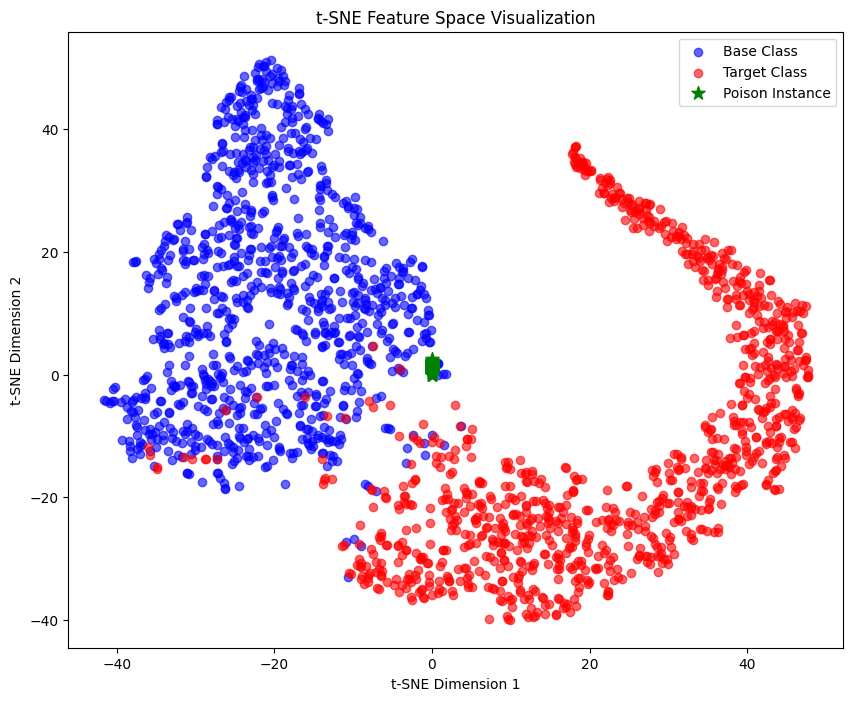

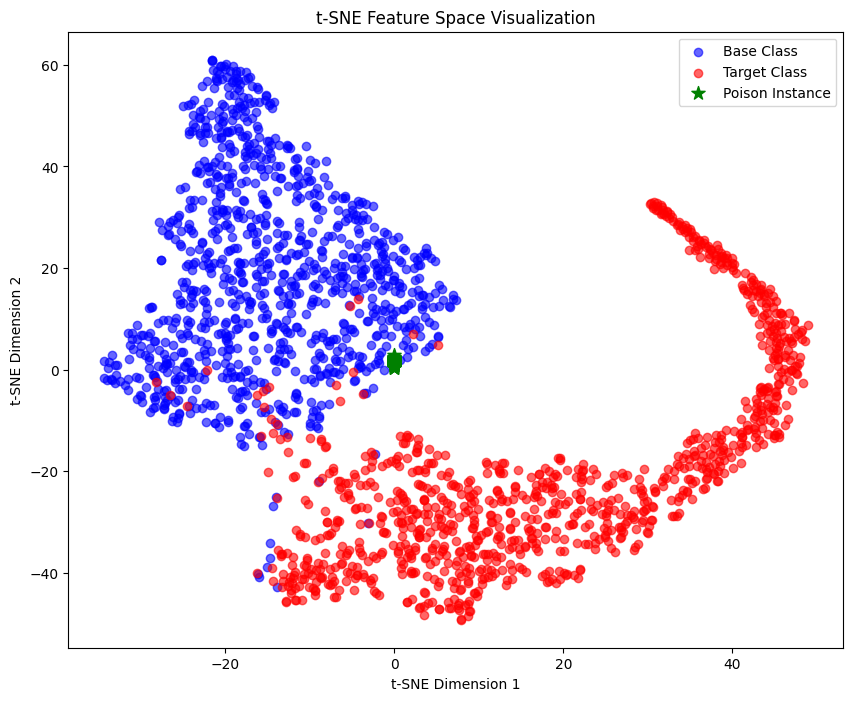

In [ ]:
# TODO: Visualize the attacked model
# clean_model
feature_space_visualization(
    clean_model,
    testloader,
    poison=torch.stack(poisons),
    base_class=base_label,
    target_class=target_label
)
# watermarked_model
feature_space_visualization(
    watermarked_model,
    testloader,
    poison=torch.stack(poisons),
    base_class=base_label,
    target_class=target_label
)

Summarize your findings.

`your response:`

The 100 poison samples initially generated were classified as the target class, but after end-to-end fine-tuning, most of them were correctly classified as the base class, as intended. However, the target instance remains correctly classified as its original target class, indicating the attack did not cause misclassification. Additionally, after watermarking, the poison samples moved closer to the centroid of the base class in the feature space, compared to their positions before the watermarking process.